In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../src/")
import hb_dic, fft_utils

# Single Watershed Analysis

## Load Data and Preprocessing

Hubbard Brook weekly stream chemistry DIC data (Unit: mmol/L)

Data is available for W6 from 01/03/1994, and for other watersheds W1~W9 from 05/28/1996

Data for HBK(?) is available in a monthly resolution from 06/17/1996, so does W101(?) but from 07/14/1997, and ML70(?) with a weekly resolution from 06/03/2013

In [3]:
watershed = "W{}".format(2) # take watershed 2 as an example because the data quality is good
dic_series = hb_dic.load_dic(watershed)
dic_series = hb_dic.clean_dic_series(dic_series)

## Plot Original Time Series

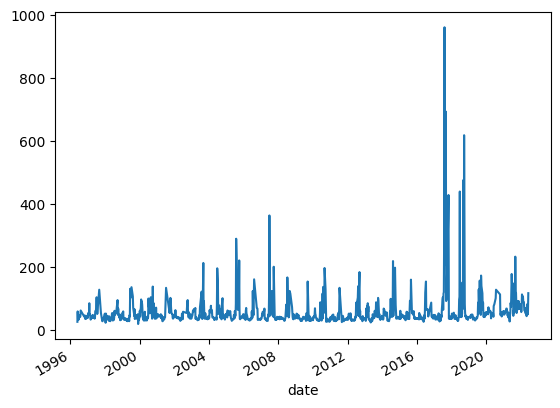

In [5]:
dic_series.plot();

## Fourier Transformation

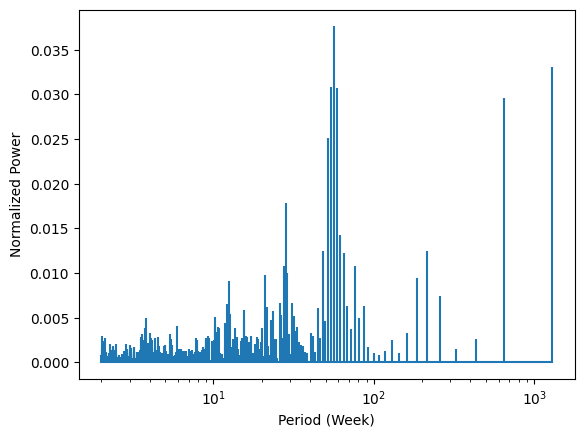

In [9]:
power_specturm = fft_utils.spectrum(dic_series)
plt.stem(power_specturm.index, power_specturm, markerfmt="", basefmt="C0-")
plt.xscale("log")
plt.xlabel("Period (Week)")
plt.ylabel("Normalized Power");

# Compare Watersheds

In [ ]:
series_fig, sfaxs = plt.subplots(3, 3, figsize=(16, 12))
spectrum_fig, spaxs = plt.subplots(3, 3, figsize=(16, 12),subplot_kw={"xlabel":"Period (Week)","ylabel":"Normalized Power","xscale":"log"})

for i in range(9):
    watershed = "W{}".format(i+1)
    # load data
    dic_series = hb_dic.load_dic(watershed)
    # preprocess data
    dic_series = hb_dic.clean_dic_series(dic_series)
    # plot original time series
    plt.sca(sfaxs.flat[i])
    dic_series.plot(ylabel="DIC (mmol/L)", title=watershed)
    # fft
    power_specturm = fft_utils.spectrum(dic_series)
    plt.sca(spaxs.flat[i])
    plt.stem(power_specturm.index, power_specturm, markerfmt="", basefmt="C0-")
    plt.title(watershed)

plt.show()
    